<style>
td, th {
   border: none!important;
}
</style>

||||
|---|---|---|
|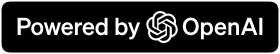|<img src="media/plusSign.jpg" alt="drawing" width="50"/>|<img src="media/PSLogo.png" alt="drawing" width="75"/>|

## How to call functions with model generated arguments

In our next example, we'll demonstrate how to execute functions whose inputs are model-generated, and use this to implement an agent that can answer questions for us about a database. For simplicity we'll use the [Chinook sample database](https://github.com/lerocha/chinook-database).

*Note:* SQL generation can be high-risk in a production environment since models are not perfectly reliable at generating correct SQL.

## Set Your OpenAI Key

In [ ]:
$env:OpenAIKey = 'sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

## Install PowerShellAI

In [1]:
$module = 'PowerShellAI'
$moduleExists = Get-Module -list $module 
if($null -eq $moduleExists) {
    Install-Module -Name $module -Force
}

Import-Module PowerShellAI -Force

### Specifying a function to execute SQL queries

First let's define some helpful utility functions to extract data from a SQL Server database.

In [2]:
function Invoke-SQL {
    param(
        $conn,
        $sql
    )

    $SqlCmd = New-Object System.Data.SqlClient.SqlCommand
    $SqlCmd.CommandText = $sql
    $SqlCmd.Connection = $conn

    $SqlAdapter = New-Object System.Data.SqlClient.SqlDataAdapter
    $SqlAdapter.SelectCommand = $SqlCmd
    
    $DataSet = New-Object System.Data.DataSet
    $null = $SqlAdapter.Fill($DataSet)
    
    $DataSet.Tables

    $conn.Close()
}

### Support functions

- Get-TableNames
- Get-ColumnNames
- Get-DatabaseInfo

In [3]:
function Get-TableNames {
    param(
        $conn
    )    
    
    Invoke-SQL $conn "SELECT TABLE_Name as Name FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE='BASE TABLE'"
}

function Get-ColumnNames {
    param(
        $conn,
        $tableName
    )    
    
    $sql = "SELECT COLUMN_NAME as Name FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME='$tableName'"
    Invoke-SQL $conn $sql
}

function Get-DatabaseInfo {
    param(
        $conn,
        [switch]$Compress,
        [switch]$Raw
    )
    
    $tables = [ordered]@{}
    $tableNames = (Get-TableNames $conn).Name
    
    foreach ($tablename in $tableNames) {
        $columns_names = (Get-ColumnNames $conn $tableName).Name
        
        if ($tables.Contains($tableName)) {
            $tables[$tableName] += $columns_names
        }
        else {
            $tables[$tableName] = @($columns_names)
        }        
    }

    if ($Raw) {
        $tables
    }
    else {
        $tables | ConvertTo-Json -Compress:$Compress
    }
}

Now can use these utility functions to extract a representation of the database schema.

In [4]:
# You need to change the Server to your own server name and database

$SqlConnection = New-Object System.Data.SqlClient.SqlConnection "Database=Chinook;Server=DESKTOP-RGI79SG\SQLEXPRESS02;Trusted_Connection=True;"

$databaseSchema = Get-DatabaseInfo $SqlConnection

Show the schema

In [5]:
$databaseSchema

{
  "Album": [
    "AlbumId",
    "Title",
    "ArtistId"
  ],
  "Artist": [
    "ArtistId",
    "Name"
  ],
  "Customer": [
    "CustomerId",
    "FirstName",
    "LastName",
    "Company",
    "Address",
    "City",
    "State",
    "Country",
    "PostalCode",
    "Phone",
    "Fax",
    "Email",
    "SupportRepId"
  ],
  "Employee": [
    "EmployeeId",
    "LastName",
    "FirstName",
    "Title",
    "ReportsTo",
    "BirthDate",
    "HireDate",
    "Address",
    "City",
    "State",
    "Country",
    "PostalCode",
    "Phone",
    "Fax",
    "Email"
  ],
  "Genre": [
    "GenreId",
    "Name"
  ],
  "Invoice": [
    "InvoiceId",
    "CustomerId",
    "InvoiceDate",
    "BillingAddress",
    "BillingCity",
    "BillingState",
    "BillingCountry",
    "BillingPostalCode",
    "Total"
  ],
  "InvoiceLine": [
    "InvoiceLineId",
    "InvoiceId",
    "TrackId",
    "UnitPrice",
    "Quantity"
  ],
  "MediaType": [
    "MediaTypeId",
    "Name"
  ],
  "Playlist": [
    "PlaylistId"

### Executing SQL queries

Now let's implement the function that will actually excute queries against the database.

In [6]:
function Invoke-AskDatabase {
    [CmdletBinding()]
    <#
        .FunctionDescription
        Function to query a SQL Server database with a provided SQL query.
        .PARAMETERDESCRIPTION query
        SQL query extracting info to answer the user's question. SQL should be written using this database schema: $databaseSchema  The query should be returned in plain text, not in JSON.
    #>
    param(        
        [string]$query
    )
    
    Write-Verbose "Querying database with query: $query"
    Invoke-Sql $SqlConnection $query
}

function Invoke-ExecuteFunctionCall {
    param(
        $message
    )
    
    if ($message.function_call.name -eq "Invoke-AskDatabase") {
        $query = ($message.function_call.arguments | ConvertFrom-Json).query
        $results = Invoke-AskDatabase $query
    }
    else {
        $results = "Error: function $message.function_call.name does not exist"
    }
    
    $results
}

We'll define a function specification for the function we'd like the API to generate arguments for.
Notice that we are inserting the database schema into the function specification. This will be important for the model to know about.

In [7]:
$functions = ConvertFrom-FunctionDefinition (Get-Command Invoke-AskDatabase)
$functions | ConvertTo-Json -Depth 5

{
  "name": "Invoke-AskDatabase",
  "description": "Function to query a SQL Server database with a provided SQL query.",
  "parameters": {
    "type": "object",
    "properties": {
      "query": {
        "type": "string",
        "description": "SQL query extracting info to answer the user's question. SQL should be written using this database schema: {\r\n  \"Album\": [\r\n    \"AlbumId\",\r\n    \"Title\",\r\n    \"ArtistId\"\r\n  ],\r\n  \"Artist\": [\r\n    \"ArtistId\",\r\n    \"Name\"\r\n  ],\r\n  \"Customer\": [\r\n    \"CustomerId\",\r\n    \"FirstName\",\r\n    \"LastName\",\r\n    \"Company\",\r\n    \"Address\",\r\n    \"City\",\r\n    \"State\",\r\n    \"Country\",\r\n    \"PostalCode\",\r\n    \"Phone\",\r\n    \"Fax\",\r\n    \"Email\",\r\n    \"SupportRepId\"\r\n  ],\r\n  \"Employee\": [\r\n    \"EmployeeId\",\r\n    \"LastName\",\r\n    \"FirstName\",\r\n    \"Title\",\r\n    \"ReportsTo\",\r\n    \"BirthDate\",\r\n    \"HireDate\",\r\n    \"Address\",\r\n    \"City\",

### Let's ask the GPT model some questions

The `system` prompt is a bit chewy. We're letting the model know we're using Microsoft SQL Server. Also, that it needs to use the TOP keyword. Provide a couple of examples. Then we give the model time to think by telling it the column names, table names and syntax needs to be correct.

In [8]:
$messages = @(
    # This helps the system understand the context of the question. THink steerability
    New-ChatMessageTemplate -Role system -Content '
Answer user questions by generating Microsoft SQL queries against the Chinook Music Database. 
- Do not user the LIMIT keyword, use TOP
    - SELECT TOP number FROM table_name WHERE condition
    - SELECT TOP (5) employee_id, last_name, first_name FROM employees 
- Make sure the column and table names are correct and exist
- The SQL syntax needs to work on Microsoft SQL Server    
'

    # Here is our question
    New-ChatMessageTemplate -Role user -Content 'Hi, who are the top 5 artists by number of tracks?'
)

$chatResponse = Get-ChatCompletion -messages $messages -functions $functions

### Let's Inspect the Response

In [9]:
$chatResponse.choices[0] | Format-List | Out-String

$chatResponse.choices[0].message | Format-List | Out-String


index         : 0
message       : @{role=assistant; content=; function_call=}
finish_reason : function_call




role          : assistant
content       : 
function_call : @{name=Invoke-AskDatabase; arguments={
                  "query": "SELECT TOP 5 Artist.Name, COUNT(Track.TrackId) AS NumberOfTracks FROM Artist JOIN Album ON Artist.ArtistId = Album.ArtistId JOIN Track ON Album.AlbumId = Track.AlbumId GROUP BY Artist.Name ORDER BY NumberOfTracks DESC;"
                }}





The response came back with `finish_reason : function_call` indicating the GPT model determined the function that needs to be invoked.

Looking at `$chatResponse.choices[0].message` we see the name of the function `Invoke-AskDatabase` and the arguments to pass. Remember we set this up when we converted from the PowerShell function `Invoke-AskDatabase` to an OpenAI Function Spec.

### Let's Invoke the Function

In [10]:
Invoke-ExecuteFunctionCall $chatResponse.choices[0].message


Name         NumberOfTracks
----         --------------
Iron Maiden             213
U2                      135
Led Zeppelin            114
Metallica               112
Deep Purple              92



### Put It All Together

In [11]:
function Invoke-SQLCopilot {
    [CmdletBinding()]
    param(
        [Parameter(Mandatory)]
        $q
    )

    $messages = @(
        # This helps the system understand the context of the question. THink steerability
        New-ChatMessageTemplate -Role system -Content '
Answer user questions by generating Microsoft SQL queries against the Chinook Music Database. 
- Do not user the LIMIT keyword, use TOP
    - SELECT TOP number FROM table_name WHERE condition
    - SELECT TOP (5) employee_id, last_name, first_name FROM employees 
- Make sure the column and table names are correct and exist
- The SQL syntax needs to work on Microsoft SQL Server    
    '
        New-ChatMessageTemplate -Role user -Content $q
    )

    $chatResponse = Get-ChatCompletion -messages $messages -functions $functions
    
    Invoke-ExecuteFunctionCall $chatResponse.choices[0].message
}


In [18]:
Invoke-SQLCopilot 'which sales agent made the most in sales in 2009?' # -Verbose


FirstName LastName TotalSales
--------- -------- ----------
Steve     Johnson     164.340



In [14]:
Invoke-SQLCopilot 'Find the top 5 tracks that have been bought most often' # -Verbose


Name                 TotalPurchases
----                 --------------
Dazed and Confused                5
The Trooper                       5
Eruption                          4
Hallowed Be Thy Name              4
Sure Know Something               4



In [16]:
Invoke-SQLCopilot 'I have no clue what I want'

Error: function @{role=assistant; content=That's okay! Do you have any specific questions or topics you'd like to learn more about? I can help you with queries related to the Chinook Music Database, such as finding information about albums, artists, tracks, customers, and more. Let me know how I can assist you!}.function_call.name does not exist
